# MTH-IDS: A Multi-Tiered Hybrid Intrusion Detection System for Internet of Vehicles
This is the code for the paper entitled "[**MTH-IDS: A Multi-Tiered Hybrid Intrusion Detection System for Internet of Vehicles**](https://arxiv.org/pdf/2105.13289.pdf)" accepted in IEEE Internet of Things Journal.  
Authors: Li Yang (liyanghart@gmail.com), Abdallah Moubayed, and Abdallah Shami  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

If you find this repository useful in your research, please cite:  
L. Yang, A. Moubayed, and A. Shami, “MTH-IDS: A Multi-Tiered Hybrid Intrusion Detection System for Internet of Vehicles,” IEEE Internet of Things Journal, vol. 9, no. 1, pp. 616-632, Jan.1, 2022.

## Import libraries

In [384]:
import warnings
warnings.filterwarnings("ignore")

In [385]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance
import joblib
import sklearn
print("sklearn version:", sklearn.__version__)



sklearn version: 1.5.1


## Read the sampled CICIDS2017 dataset
The CICIDS2017 dataset is publicly available at: https://www.unb.ca/cic/datasets/ids-2017.html  
Due to the large size of this dataset, the sampled subsets of CICIDS2017 is used. The subsets are in the "data" folder.  
If you want to use this code on other datasets (e.g., CAN-intrusion dataset), just change the dataset name and follow the same steps. The models in this code are generic models that can be used in any intrusion detection/network traffic datasets.

In [386]:
#Read dataset
df = pd.read_csv('./data/CICIDS2017_sample.csv') 
# The results in this code is based on the original CICIDS2017 dataset. Please go to cell [21] if you work on the sampled dataset. 

In [387]:
df

# Save the training features
training_features = df.columns.tolist()
joblib.dump(training_features, './features/training_features.joblib')


['./features/training_features.joblib']

In [388]:
df.Label.value_counts()

Label
BENIGN          22731
DoS             19035
PortScan         7946
BruteForce       2767
WebAttack        2180
Bot              1966
Infiltration       36
Name: count, dtype: int64

### Preprocessing (normalization and padding values)

In [389]:
# Z-score normalization
features = df.dtypes[df.dtypes != 'object'].index
# df[features] = df[features].apply(
#     lambda x: (x - x.mean()) / (x.std()))



df = df.replace([float('inf'), float('-inf')], 0) 
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

joblib.dump(scaler, './scalers/scaler.joblib')

# # Fill empty values by 0          TODO: Trying out this before scaling 
df = df.fillna(0)


df.head()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,-0.528474,-0.068427,-0.081807,-0.032573,-0.048344,-0.202328,-0.085799,-0.141626,-0.176450,-0.559724,...,-1.023422,-0.10989,-0.081787,-0.128621,-0.094861,-0.458733,-0.137652,-0.466444,-0.442061,BENIGN
1,-0.524597,0.704885,0.850348,0.027749,0.920418,0.603280,-0.211176,-0.082435,0.240598,1.006311,...,-1.023422,-0.10989,-0.081787,-0.128621,-0.094861,-0.458733,-0.137652,-0.466444,-0.442061,BENIGN
2,-0.525237,0.300654,0.339166,0.020443,0.363715,0.603280,-0.211176,0.044065,0.439623,0.484299,...,0.742122,-0.10989,-0.081787,-0.128621,-0.094861,-0.458733,-0.137652,-0.466444,-0.442061,BENIGN
3,-0.524565,0.652159,0.745105,0.026625,0.933542,0.603280,-0.211176,-0.074097,0.257380,1.006311,...,-1.023422,-0.10989,-0.081787,-0.128621,-0.094861,-0.458733,-0.137652,-0.466444,-0.442061,BENIGN
4,-0.524560,0.757610,0.805244,0.028030,0.960045,0.603280,-0.211176,-0.091862,0.225736,1.006311,...,-1.023422,-0.10989,-0.081787,-0.128621,-0.094861,-0.458733,-0.137652,-0.466444,-0.442061,BENIGN


### Data sampling
Due to the space limit of GitHub files and the large size of network traffic data, we sample a small-sized subset for model learning using **k-means cluster sampling**

In [390]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])

In [391]:
df.Label.value_counts()

Label
0    22731
3    19035
5     7946
2     2767
6     2180
1     1966
4       36
Name: count, dtype: int64

In [392]:
# retain the minority class instances and sample the majority class instances
df_minor = df[(df['Label']==6)|(df['Label']==1)|(df['Label']==4)]
df_major = df.drop(df_minor.index)

In [393]:
X = df_major.drop(['Label'],axis=1) 
y = df_major.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [394]:
# use k-means to cluster the data samples and select a proportion of data from each cluster
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=1000, random_state=0).fit(X)

In [395]:
klabel=kmeans.labels_
df_major['klabel']=klabel

In [396]:
df_major['klabel'].value_counts()

klabel
802    522
915    481
308    348
319    337
715    334
      ... 
212      2
712      1
804      1
398      1
743      1
Name: count, Length: 974, dtype: int64

In [397]:
cols = list(df_major)
cols.insert(78, cols.pop(cols.index('Label')))
df_major = df_major.loc[:, cols]

In [398]:
df_major

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,klabel,Label
0,-0.528474,-0.068427,-0.081807,-0.032573,-0.048344,-0.202328,-0.085799,-0.141626,-0.176450,-0.559724,...,-0.109890,-0.081787,-0.128621,-0.094861,-0.458733,-0.137652,-0.466444,-0.442061,393,0
1,-0.524597,0.704885,0.850348,0.027749,0.920418,0.603280,-0.211176,-0.082435,0.240598,1.006311,...,-0.109890,-0.081787,-0.128621,-0.094861,-0.458733,-0.137652,-0.466444,-0.442061,303,0
2,-0.525237,0.300654,0.339166,0.020443,0.363715,0.603280,-0.211176,0.044065,0.439623,0.484299,...,-0.109890,-0.081787,-0.128621,-0.094861,-0.458733,-0.137652,-0.466444,-0.442061,457,0
3,-0.524565,0.652159,0.745105,0.026625,0.933542,0.603280,-0.211176,-0.074097,0.257380,1.006311,...,-0.109890,-0.081787,-0.128621,-0.094861,-0.458733,-0.137652,-0.466444,-0.442061,303,0
4,-0.524560,0.757610,0.805244,0.028030,0.960045,0.603280,-0.211176,-0.091862,0.225736,1.006311,...,-0.109890,-0.081787,-0.128621,-0.094861,-0.458733,-0.137652,-0.466444,-0.442061,303,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56656,-0.528468,-0.068427,-0.051737,-0.031309,-0.046220,-0.200833,0.457502,-0.064078,-0.255106,-0.517906,...,-0.109890,-0.081787,-0.128621,-0.094861,-0.458733,-0.137652,-0.466444,-0.442061,204,0
56657,-0.524845,-0.068427,-0.051737,-0.029904,-0.043932,-0.178414,0.770945,0.022086,-0.255106,-0.472842,...,-0.109890,-0.081787,-0.128621,-0.094861,-0.458733,-0.137652,-0.466444,-0.442061,638,0
56658,-0.215113,-0.015701,-0.021668,-0.013231,-0.016083,0.423924,-0.211176,0.269091,0.640334,0.711057,...,-0.108683,-0.081787,-0.127670,-0.093555,-0.256388,-0.137652,-0.269451,-0.238254,547,3
56659,-0.215113,0.037025,0.008402,-0.014823,0.058110,0.373106,-0.211176,0.050808,0.399315,1.528323,...,-0.108677,-0.081787,-0.127665,-0.093549,-0.256404,-0.137652,-0.269466,-0.238270,30,3


In [399]:
def typicalSampling(group):
    name = group.name
    frac = 0.008
    return group.sample(frac=frac)

result = df_major.groupby(
    'klabel', group_keys=False
).apply(typicalSampling)

In [400]:
result['Label'].value_counts()

Label
0    120
3    114
5     64
2     18
Name: count, dtype: int64

In [401]:
result

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,klabel,Label
48601,1.800590,0.037025,0.008402,-0.017212,0.057771,0.287912,-0.211176,0.014188,0.308375,1.528323,...,-0.105814,-0.081787,-0.125409,-0.090450,2.198274,-0.137652,2.120302,2.234155,2,3
47732,2.199230,-0.015701,0.023437,-0.017305,0.057771,0.275955,-0.211176,0.169141,0.437496,1.528323,...,-0.095039,-0.081787,-0.116921,-0.078792,2.652516,-0.137652,2.562533,2.691681,4,3
34884,-0.523790,-0.033276,-0.021668,-0.025314,-0.043768,-0.176919,0.791842,0.027831,-0.255106,-0.514661,...,-0.109890,-0.081787,-0.128621,-0.094861,-0.458733,-0.137652,-0.466444,-0.442061,6,0
6662,-0.480805,-0.050851,-0.021668,-0.033089,0.057881,-0.218769,-0.211176,-0.198112,-0.209440,3.620336,...,-0.109890,-0.081787,-0.128621,-0.094861,-0.458733,-0.137652,-0.466444,-0.442061,11,3
6826,-0.388195,-0.015701,-0.081807,-0.032901,-0.048344,-0.239693,-0.085799,-0.213430,-0.255106,-0.559724,...,-0.108609,-0.081787,-0.127611,-0.093474,-0.298485,-0.137652,-0.310434,-0.280655,12,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3612,-0.445424,-0.033276,-0.081807,-0.033182,-0.048344,-0.239693,-0.085799,-0.213430,-0.255106,-0.559724,...,-0.109890,-0.081787,-0.128621,-0.094861,-0.458733,-0.137652,-0.466444,-0.442061,980,3
7814,2.610017,0.177627,0.128680,-0.009578,-0.039329,0.414956,-0.211176,-0.058334,0.232602,-0.206789,...,-0.038928,0.129992,0.154505,-0.049467,-0.148142,-0.127824,-0.163547,-0.135063,984,0
38773,-0.527639,-0.068427,-0.051737,-0.031309,-0.046733,-0.200833,0.457502,-0.064078,-0.255106,-0.528000,...,-0.109890,-0.081787,-0.128621,-0.094861,-0.458733,-0.137652,-0.466444,-0.442061,992,0
33274,-0.451495,0.019450,0.008402,-0.001054,-0.041910,0.401504,-0.211176,0.334741,0.493825,-0.369738,...,-0.109890,-0.081787,-0.128621,-0.094861,-0.458733,-0.137652,-0.466444,-0.442061,995,0


In [402]:
result = result.drop(['klabel'],axis=1)
result = result._append(df_minor)

In [403]:
result.to_csv('./data/CICIDS2017_sample_km.csv',index=0)

### split train set and test set

In [404]:
# Read the sampled dataset
df=pd.read_csv('./data/CICIDS2017_sample_km.csv')

In [405]:
X = df.drop(['Label'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [406]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

## Feature engineering

### Feature selection by information gain

In [407]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train)

In [408]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [409]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [410]:
X_fs = df[fs].values

In [411]:
X_fs.shape

(4498, 43)

### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [412]:
def count_vals(x):
    vals = np.unique(x)
    occ = np.zeros(shape = vals.shape)    
    for i in range(vals.size):
        occ[i] = np.sum(x == vals[i])
    return occ

def entropy(x):
    n = float(x.shape[0])
    ocurrence = count_vals(x)
    px = ocurrence / n
    return -1* np.sum(px*np.log2(px))

def symmetricalUncertain(x,y):
    n = float(y.shape[0])
    vals = np.unique(y)
    # Computing Entropy for the feature x. 
    Hx = entropy(x)
    # Computing Entropy for the feature y.
    Hy = entropy(y)
    #Computing Joint entropy between x and y.
    partial = np.zeros(shape = (vals.shape[0]))
    for i in range(vals.shape[0]):    
       partial[i] = entropy(x[y == vals[i]]) 
    
    partial[np.isnan(partial)==1] = 0      
    py = count_vals(y).astype(dtype = 'float64') / n
    Hxy = np.sum(py[py > 0]*partial) 
    IG = Hx-Hxy
    return 2*IG/(Hx+Hy)

def suGroup(x, n):
    m = x.shape[0]
    x = np.reshape(x, (n,int(m//n))).T
    m = x.shape[1]
    SU_matrix = np.zeros(shape = (m,m))
    for j in range(m-1):
        x2 = x[:,j+1::]
        y = x[:,j]
        temp = np.apply_along_axis(symmetricalUncertain, 0, x2, y)
        for k in range(temp.shape[0]):
            SU_matrix[j,j+1::] = temp
            SU_matrix[j+1::,j] = temp
    
    return 1/float(m-1)*np.sum(SU_matrix, axis = 1)

def isprime(a):
    return all(a % i for i in range(2, a))


"""
get
"""

def get_i(a):
    if isprime(a):
        a -= 1
    return filter(lambda x: a % x == 0, range(2,a))


"""
FCBF - Fast Correlation Based Filter

L. Yu and H. Liu. Feature Selection for High‐Dimensional Data: A Fast Correlation‐Based Filter Solution. 
In Proceedings of The Twentieth International Conference on Machine Leaning (ICML‐03), 856‐863.
Washington, D.C., August 21‐24, 2003.
"""

class FCBF:
    
    idx_sel = []
    
    
    def __init__(self, th = 0.01):
        '''
        Parameters
        ---------------
            th = The initial threshold 
        '''
        self.th = th


    def fit(self, x, y):
        '''
        This function executes FCBF algorithm and saves indexes 
        of selected features in self.idx_sel
        
        Parameters
        ---------------
            x = dataset  [NxM] 
            y = label    [Nx1]
        '''
        self.idx_sel = []
        """
        First Stage: Computing the SU for each feature with the response.
        """
        SU_vec = np.apply_along_axis(symmetricalUncertain, 0, x, y)
        SU_list = SU_vec[SU_vec > self.th]
        SU_list[::-1].sort()
        
        m = x[:,SU_vec > self.th].shape
        x_sorted = np.zeros(shape = m)
        
        for i in range(m[1]):
            ind = np.argmax(SU_vec)
            SU_vec[ind] = 0
            x_sorted[:,i] = x[:,ind].copy()
            self.idx_sel.append(ind)
        
        """
        Second Stage: Identify relationships between feature to remove redundancy.
        """
        j = 0
        while True:
            """
            Stopping Criteria:The search finishes
            """
            if j >= x_sorted.shape[1]: break
            y = x_sorted[:,j].copy()
            x_list = x_sorted[:,j+1:].copy()
            if x_list.shape[1] == 0: break
                
                
            SU_list_2 = SU_list[j+1:]
            SU_x = np.apply_along_axis(symmetricalUncertain, 0, 
                                       x_list, y)
            
            comp_SU = SU_x >= SU_list_2
            to_remove = np.where(comp_SU)[0] + j + 1 
            if to_remove.size > 0:
                x_sorted = np.delete(x_sorted, to_remove, axis = 1)
                SU_list = np.delete(SU_list, to_remove, axis = 0)
                to_remove.sort()
                for r in reversed(to_remove): 
                    self.idx_sel.remove(self.idx_sel[r])
            j = j + 1        
            
    def fit_transform(self, x, y):
        '''
        This function fits the feature selection 
        algorithm and returns the resulting subset.
        
        Parameters
        ---------------
            x = dataset  [NxM] 
            y = label    [Nx1]
        '''
        self.fit(x, y)
        return x[:,self.idx_sel]
         
    def transform(self, x):
        '''
        This function applies the selection
        to the vector x.
        
        Parameters
        ---------------
            x = dataset  [NxM] 
        '''
        return x[:, self.idx_sel]  


"""
FCBF# - Fast Correlation Based Filter 
B. Senliol, G. Gulgezen, et al. Fast Correlation Based Filter (FCBF) with a Different Search Strategy. 
In Computer and Information Sciences (ISCIS ‘08) 23rd International Symposium on, pages 1‐4. 
Istanbul, October 27‐29, 2008.
"""
class FCBFK(FCBF):
    
    idx_sel = []
    
    
    def __init__(self, k = 10):
        '''
        Parameters
        ---------------
            k = Number of features to include in the
            subset.
        '''
        self.k = k


    def fit(self, x, y):
        '''
        This function executes FCBFK algorithm and saves indexes 
        of selected features in self.idx_sel
        
        Parameters
        ---------------
            x = dataset  [NxM] 
            y = label    [Nx1]
        '''        
        self.idx_sel = []
        """
        First Stage: Computing the SU for each feature with the response.
        """    
        SU_vec = np.apply_along_axis(symmetricalUncertain, 0, x, y)
        
        SU_list = SU_vec[SU_vec > 0]
        SU_list[::-1].sort()
        
        m = x[:,SU_vec > 0].shape
        x_sorted = np.zeros(shape = m)
        
        for i in range(m[1]):
            ind = np.argmax(SU_vec)
            SU_vec[ind] = 0
            x_sorted[:,i] = x[:,ind].copy() 
            self.idx_sel.append(ind)
            
        """
        Second Stage: Identify relationships between features to remove redundancy with stopping 
        criteria (features in x_best == k).
        """    
        j = 0
        while True:
            y = x_sorted[:,j].copy()
            SU_list_2 = SU_list[j+1:]    
            x_list = x_sorted[:,j+1:].copy()
            
            """
            Stopping Criteria:The search finishes
            """
            if x_list.shape[1] == 0: break
                
                
            SU_x = np.apply_along_axis(symmetricalUncertain, 0, 
                                       x_list, y)
            
            comp_SU = SU_x >= SU_list_2
            to_remove = np.where(comp_SU)[0] + j + 1 
            if to_remove.size > 0 and x.shape[1] > self.k:
    
                for i in reversed(to_remove):
                    
                    x_sorted = np.delete(x_sorted, i, axis = 1)
                    SU_list = np.delete(SU_list, i, axis = 0)                
                    self.idx_sel.remove(self.idx_sel[i])
                    if x_sorted.shape[1] == self.k: break  
                    
            if x_list.shape[1] == 1 or x_sorted.shape[1] == self.k: 
                break    
            j = j + 1
            
        if len(self.idx_sel) > self.k:
            self.idx_sel = self.idx_sel[:self.k]
            
            
            
"""
FCBFiP - Fast Correlation Based Filter in Pieces
"""            
            
class FCBFiP(FCBF):
    
    idx_sel = []


    def __init__(self, k = 10, npieces = 2):
        '''
        Parameters
        ---------------
            k = Number of features to include in the
            subset.
            npieces = Number of pieces to divide the 
            feature space.
        '''
        self.k = k
        self.npieces = npieces

    def fit(self, x, y):
        '''
        This function executes FCBF algorithm and saves indexes 
        of selected features in self.idx_sel
        
        Parameters
        ---------------
            x = dataset  [NxM] 
            y = label    [Nx1]
        '''
    
        """
        First Stage: Computing the SU for each feature with the response. We sort the 
        features. When we have a prime number of features we remove the last one from the
        sorted features list.
        """      
        m = x.shape
        nfeaturesPieces = int(m[1] / float(self.npieces))        
        SU_vec = np.apply_along_axis(symmetricalUncertain, 0, x, y)
        
        x_sorted = np.zeros(shape = m, dtype = 'float64')        
        idx_sorted = np.zeros(shape = m[1], dtype = 'int64')
        for i in range(m[1]):
            ind = np.argmax(SU_vec)
            SU_vec[ind] = -1
            idx_sorted[i]= ind 
            x_sorted[:,i] = x[:,ind].copy() 

        if isprime(m[1]): 
            x_sorted = np.delete(x_sorted, m[1]-1, axis = 1 )
            ind_prime = idx_sorted[m[1]-1]
            idx_sorted = np.delete(idx_sorted, m[1]-1)
            #m = x_sorted.shape
        """
        Second Stage: Identify relationships between features into its vecinity
        to remove redundancy with stopping criteria (features in x_best == k).
        """   
        
        x_2d = np.reshape(x_sorted.T, (self.npieces, nfeaturesPieces*m[0])).T
    
        SU_x =  np.apply_along_axis(suGroup, 0, x_2d, nfeaturesPieces)
        SU_x = np.reshape(SU_x.T, (self.npieces*nfeaturesPieces,))
        idx_sorted2 = np.zeros(shape = idx_sorted.shape, dtype = 'int64')
        SU_x[np.isnan(SU_x)] = 1        
        
        for i in range(idx_sorted.shape[0]):
            ind =  np.argmin(SU_x)
            idx_sorted2[i] = idx_sorted[ind]
            SU_x[ind] = 10    
        
        """
        Scoring step
        """        
        self.scores = np.zeros(shape = m[1], dtype = 'int64') 
           
        for i in range(m[1]):
            if i in idx_sorted:
                self.scores[i] = np.argwhere(i == idx_sorted) + np.argwhere(i == idx_sorted2)
        if isprime(m[1]): 
            self.scores[ind_prime] = 2*m[1]
        self.set_k(self.k)


    def set_k(self, k):
        self.k = k 
        scores_temp = -1*self.scores
        
        self.idx_sel = np.zeros(shape = self.k, dtype = 'int64')
        for i in range(self.k):
            ind =  np.argmax(scores_temp)
            scores_temp[ind] = -100000000
            self.idx_sel[i] = ind





fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [413]:
X_fss = fcbf.fit_transform(X_fs,y)

#Save the selected features
selected_indices = fcbf.idx_sel 
selected_features = df.columns[selected_indices]  
print(selected_features.tolist())
joblib.dump(selected_features.tolist(), './features/selected_features.joblib')

['Flow IAT Min', 'Fwd Packet Length Mean', 'Flow Duration', 'Total Fwd Packets', 'Bwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Fwd Packet Length Min', 'Total Backward Packets', 'Fwd Packet Length Std', 'Bwd Packet Length Mean', 'Fwd Packet Length Max', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd PSH Flags', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd URG Flags', 'Fwd Packets/s', 'Bwd Packets/s']


['./features/selected_features.joblib']

In [414]:
X_fss.shape

(4498, 20)

### Re-split train & test sets after feature selection

In [415]:
X_train, X_test, y_train, y_test = train_test_split(X_fss,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [416]:
X_train.shape

(3598, 20)

In [417]:
pd.Series(y_train).value_counts()

6    1744
1    1573
0      96
3      91
5      51
4      29
2      14
Name: count, dtype: int64

### SMOTE to solve class-imbalance

In [418]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy={2:1000,4:1000})

In [419]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [420]:
pd.Series(y_train).value_counts()

6    1744
1    1573
4    1000
2    1000
0      96
3      91
5      51
Name: count, dtype: int64

In [421]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy={2:1000,4:1000})

## Machine learning model training

### Training four base learners: decision tree, random forest, extra trees, XGBoost

#### Apply XGBoost

Accuracy of XGBoost: 0.9966666666666667
Precision of XGBoost: 0.9968157026889903
Recall of XGBoost: 0.9966666666666667
F1-score of XGBoost: 0.9965951351809476
              precision    recall  f1-score   support

           0       1.00      0.88      0.93        24
           1       1.00      1.00      1.00       393
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00        23
           4       0.88      1.00      0.93         7
           5       1.00      1.00      1.00        13
           6       1.00      1.00      1.00       436

    accuracy                           1.00       900
   macro avg       0.98      0.98      0.98       900
weighted avg       1.00      1.00      1.00       900



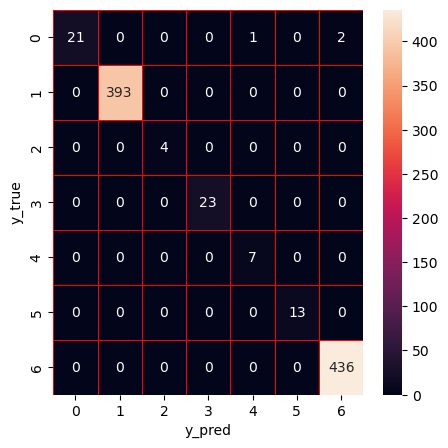

In [422]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of XGBoost using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [423]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:06<00:00,  3.12trial/s, best loss: -0.9988888888888889]
XGBoost: Hyperopt estimated optimum {'learning_rate': 1.2880516036722331, 'max_depth': 88.0, 'n_estimators': 45.0}


Accuracy of XGBoost: 0.9988888888888889
Precision of XGBoost: 0.9990277777777777
Recall of XGBoost: 0.9988888888888889
F1-score of XGBoost: 0.9989141055949567
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        24
           1       1.00      1.00      1.00       393
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00        23
           4       0.88      1.00      0.93         7
           5       1.00      1.00      1.00        13
           6       1.00      1.00      1.00       436

    accuracy                           1.00       900
   macro avg       0.98      0.99      0.99       900
weighted avg       1.00      1.00      1.00       900



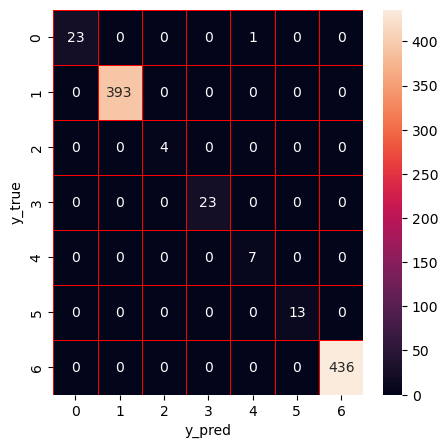

In [424]:
xg = xgb.XGBClassifier(learning_rate= 0.7340229699980686, n_estimators = 70, max_depth = 14)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [425]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

#### Apply RF

Accuracy of RF: 0.9977777777777778
Precision of RF: 0.9979192092550215
Recall of RF: 0.9977777777777778
F1-score of RF: 0.997802923144969
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        24
           1       1.00      1.00      1.00       393
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00        23
           4       0.88      1.00      0.93         7
           5       1.00      1.00      1.00        13
           6       1.00      1.00      1.00       436

    accuracy                           1.00       900
   macro avg       0.98      0.99      0.99       900
weighted avg       1.00      1.00      1.00       900



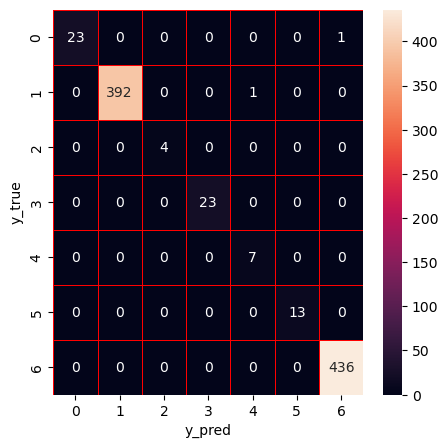

In [426]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) 
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of random forest using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [427]:
# Hyperparameter optimization of random forest
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = RandomForestClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:14<00:00,  1.36trial/s, best loss: -0.9977777777777778]
Random Forest: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 45.0, 'max_features': 7.0, 'min_samples_leaf': 1.0, 'min_samples_split': 6.0, 'n_estimators': 20.0}


<class 'numpy.ndarray'>
[-1.02342176 -0.581691   -0.04934834 -0.04934834 -0.55972423 -0.59874409
 -0.59874409 -0.56737344 -0.2576803  -0.04839057 -0.04834351 -0.10745475
 -0.61328167 -0.61515488 -0.23969349 -0.03290131 -0.03290131 -0.21342998
 -0.0818066  -0.0818066 ]
Accuracy of RF: 0.9944444444444445
Precision of RF: 0.9944327859208826
Recall of RF: 0.9944444444444445
F1-score of RF: 0.9942990504182206
              precision    recall  f1-score   support

           0       0.95      0.83      0.89        24
           1       0.99      1.00      1.00       393
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00        23
           4       0.88      1.00      0.93         7
           5       1.00      1.00      1.00        13
           6       1.00      1.00      1.00       436

    accuracy                           0.99       900
   macro avg       0.97      0.98      0.97       900
weighted avg       0.99      0.99      0.99       

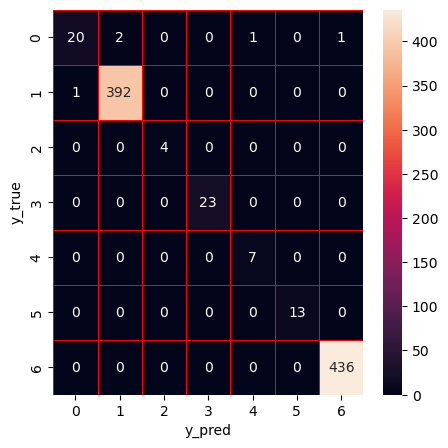

In [428]:
rf_hpo = RandomForestClassifier(n_estimators = 71, min_samples_leaf = 1, max_depth = 46, min_samples_split = 9, max_features = 20, criterion = 'entropy')
rf_hpo.fit(X_train,y_train)
rf_score=rf_hpo.score(X_test,y_test)
y_predict=rf_hpo.predict(X_test)
y_true=y_test

joblib.dump(rf_hpo, './models/clf_rf.joblib')
print(type(X_test))
print(X_test[0])

print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [429]:
rf_train=rf_hpo.predict(X_train)
rf_test=rf_hpo.predict(X_test)

#### Apply DT

Accuracy of DT: 0.9955555555555555
Precision of DT: 0.9960982216007006
Recall of DT: 0.9955555555555555
F1-score of DT: 0.9955048809486003
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        24
           1       1.00      1.00      1.00       393
           2       1.00      1.00      1.00         4
           3       0.96      1.00      0.98        23
           4       0.78      1.00      0.88         7
           5       1.00      1.00      1.00        13
           6       1.00      1.00      1.00       436

    accuracy                           1.00       900
   macro avg       0.96      0.98      0.97       900
weighted avg       1.00      1.00      1.00       900



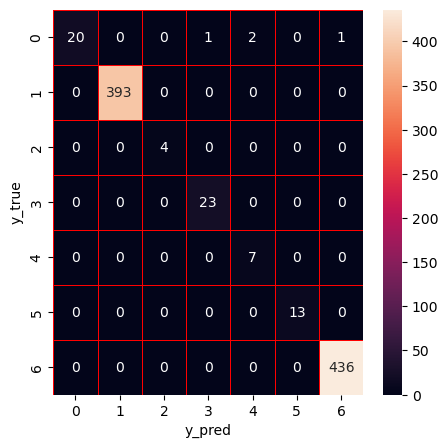

In [430]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train) 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of decision tree using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [431]:
# Hyperparameter optimization of decision tree
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = DecisionTreeClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)
print("Decision tree: Hyperopt estimated optimum {}".format(best))

100%|██████████| 50/50 [00:00<00:00, 67.24trial/s, best loss: -0.9944444444444445]
Decision tree: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 30.0, 'max_features': 8.0, 'min_samples_leaf': 1.0, 'min_samples_split': 11.0}


Accuracy of DT: 0.9888888888888889
Precision of DT: 0.9894239037888464
Recall of DT: 0.9888888888888889
F1-score of DT: 0.9890335744593333
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        24
           1       1.00      0.99      1.00       393
           2       1.00      1.00      1.00         4
           3       0.96      1.00      0.98        23
           4       0.78      1.00      0.88         7
           5       1.00      1.00      1.00        13
           6       1.00      0.99      0.99       436

    accuracy                           0.99       900
   macro avg       0.93      0.97      0.95       900
weighted avg       0.99      0.99      0.99       900



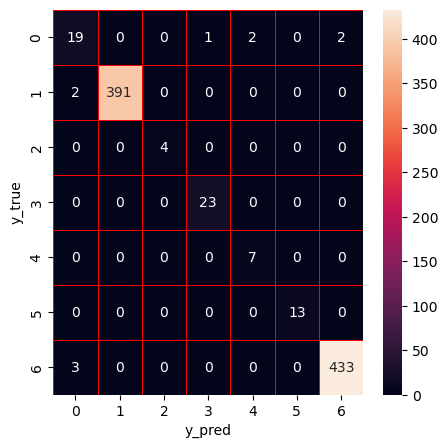

In [432]:
dt_hpo = DecisionTreeClassifier(min_samples_leaf = 2, max_depth = 47, min_samples_split = 3, max_features = 19, criterion = 'gini')
dt_hpo.fit(X_train,y_train)
dt_score=dt_hpo.score(X_test,y_test)
y_predict=dt_hpo.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [433]:
dt_train=dt_hpo.predict(X_train)
dt_test=dt_hpo.predict(X_test)

#### Apply ET

Accuracy of ET: 0.9988888888888889
Precision of ET: 0.9990277777777777
Recall of ET: 0.9988888888888889
F1-score of ET: 0.9989252182118424
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00       393
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00        23
           4       0.88      1.00      0.93         7
           5       1.00      1.00      1.00        13
           6       1.00      1.00      1.00       436

    accuracy                           1.00       900
   macro avg       0.98      1.00      0.99       900
weighted avg       1.00      1.00      1.00       900



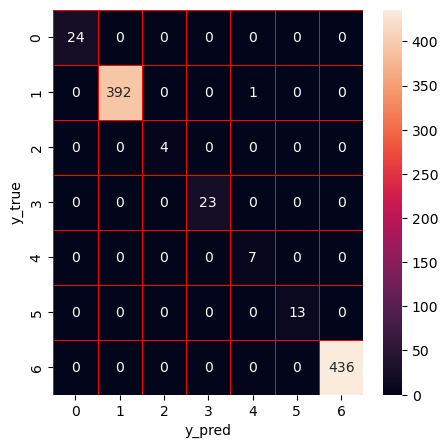

In [434]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train) 
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of extra trees using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [435]:
# Hyperparameter optimization of extra trees
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = ExtraTreesClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:04<00:00,  4.57trial/s, best loss: -0.9988888888888889]
Random Forest: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 21.0, 'max_features': 12.0, 'min_samples_leaf': 1.0, 'min_samples_split': 4.0, 'n_estimators': 152.0}


Accuracy of ET: 0.9977777777777778
Precision of ET: 0.9977777777777778
Recall of ET: 0.9977777777777778
F1-score of ET: 0.9977777777777778
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        24
           1       1.00      1.00      1.00       393
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00        23
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00        13
           6       1.00      1.00      1.00       436

    accuracy                           1.00       900
   macro avg       0.99      0.99      0.99       900
weighted avg       1.00      1.00      1.00       900



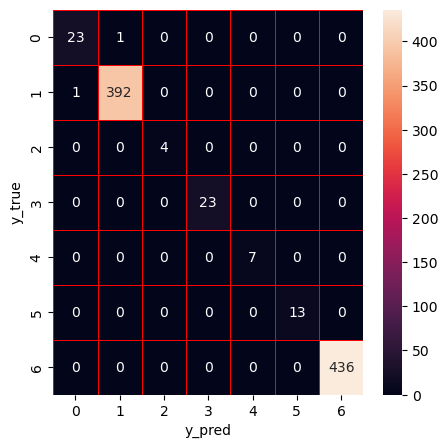

In [436]:
et_hpo = ExtraTreesClassifier(n_estimators = 53, min_samples_leaf = 1, max_depth = 31, min_samples_split = 5, max_features = 20, criterion = 'entropy')
et_hpo.fit(X_train,y_train) 
et_score=et_hpo.score(X_test,y_test)
y_predict=et_hpo.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [437]:
et_train=et_hpo.predict(X_train)
et_test=et_hpo.predict(X_test)

### Apply Stacking
The ensemble model that combines the four ML models (DT, RF, ET, XGBoost)

In [438]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,6,6,6,6
1,1,1,1,1
2,6,6,6,6
3,1,1,1,1
4,6,6,6,6


In [439]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [440]:
dt_train.shape

(5555, 1)

In [441]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.9966666666666667
Precision of Stacking: 0.9967572463768116
Recall of Stacking: 0.9966666666666667
F1-score of Stacking: 0.996668242710796
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        24
           1       1.00      1.00      1.00       393
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00        23
           4       0.88      1.00      0.93         7
           5       1.00      1.00      1.00        13
           6       1.00      1.00      1.00       436

    accuracy                           1.00       900
   macro avg       0.98      0.99      0.98       900
weighted avg       1.00      1.00      1.00       900



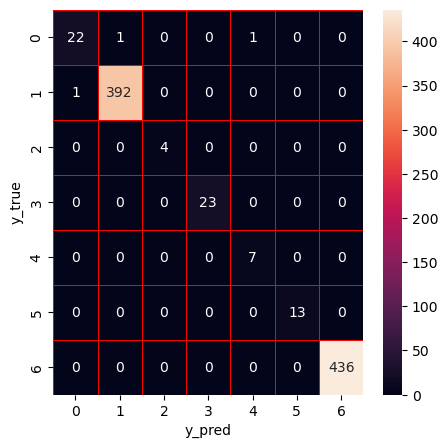

In [442]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of the stacking ensemble model (XGBoost) using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [443]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:02<00:00,  8.01trial/s, best loss: -0.9988888888888889]
XGBoost: Hyperopt estimated optimum {'learning_rate': 0.06311348833663592, 'max_depth': 46.0, 'n_estimators': 50.0}


Accuracy of XGBoost: 0.9977777777777778
Precision of XGBoost: 0.9979166666666667
Recall of XGBoost: 0.9977777777777778
F1-score of XGBoost: 0.9978141071007314
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        24
           1       1.00      1.00      1.00       393
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00        23
           4       0.88      1.00      0.93         7
           5       1.00      1.00      1.00        13
           6       1.00      1.00      1.00       436

    accuracy                           1.00       900
   macro avg       0.98      0.99      0.98       900
weighted avg       1.00      1.00      1.00       900



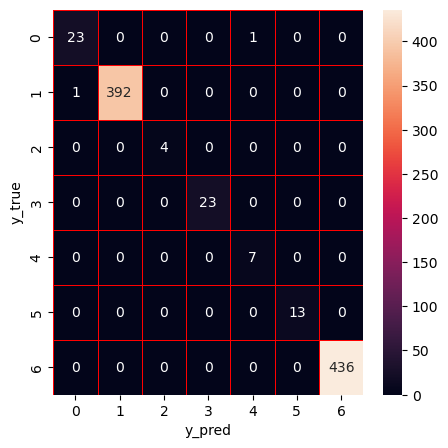

In [444]:
xg = xgb.XGBClassifier(learning_rate= 0.19229249758051492, n_estimators = 30, max_depth = 36)
xg.fit(x_train,y_train)
xg_score=xg.score(x_test,y_test)
y_predict=xg.predict(x_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Anomaly-based IDS

### Generate the port-scan datasets for unknown attack detection

In [445]:
df=pd.read_csv('./data/CICIDS2017_sample_km.csv')

In [446]:
df.Label.value_counts()

Label
6    2180
1    1966
0     120
3     114
5      64
4      36
2      18
Name: count, dtype: int64

In [447]:
df1 = df[df['Label'] != 5]
df1['Label'][df1['Label'] > 0] = 1
df1.to_csv('./data/CICIDS2017_sample_km_without_portscan.csv',index=0)

In [448]:
df2 = df[df['Label'] == 5]
df2['Label'][df2['Label'] == 5] = 1
df2.to_csv('./data/CICIDS2017_sample_km_portscan.csv',index=0)

### Read the generated datasets for unknown attack detection

In [449]:
df1 = pd.read_csv('./data/CICIDS2017_sample_km_without_portscan.csv')
df2 = pd.read_csv('./data/CICIDS2017_sample_km_portscan.csv')

In [450]:
features = df1.drop(['Label'],axis=1).dtypes[df1.dtypes != 'object'].index
df1[features] = df1[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df2[features] = df2[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df1 = df1.fillna(0)
df2 = df2.fillna(0)

In [451]:
df1.Label.value_counts()

Label
1    4314
0     120
Name: count, dtype: int64

In [452]:
df2.Label.value_counts()

Label
1    64
Name: count, dtype: int64

In [453]:
df2p=df1[df1['Label']==0]
df2pp=df2p.sample(n=None, frac=1255/18225, replace=False, weights=None, random_state=None, axis=0)
df2=pd.concat([df2, df2pp])

In [454]:
df2.Label.value_counts()

Label
1    64
0     8
Name: count, dtype: int64

In [455]:
df = df1._append(df2)

In [456]:
X = df.drop(['Label'],axis=1) .values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
pd.Series(y).value_counts()

1    4378
0     128
Name: count, dtype: int64

### Feature engineering (IG, FCBF, and KPCA)

#### Feature selection by information gain (IG)

In [457]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X, y)

In [458]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [459]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [460]:
X_fs = df[fs].values

In [461]:
X_fs.shape

(4506, 43)

In [462]:
X_fs

array([[-1.23422597, -0.06306226, -0.06306226, ..., -0.08164702,
        -0.0430758 , -0.04960396],
       [-1.25578791, -0.06308867, -0.06308867, ..., -0.08047663,
        -0.04154261, -0.04960396],
       [-1.2558666 , -0.06534742, -0.06534742, ..., -0.08164471,
        -0.04298819, -0.04308556],
       ...,
       [-1.2558666 , -0.06728916, -0.06728916, ..., -0.08164818,
         0.98701021, -0.06264076],
       [-1.17520606, -0.06783073, -0.06783073, ..., -0.08159151,
        -0.0430758 , -0.05612236],
       [-1.2558666 , -0.06669475, -0.06669475, ..., -0.08159267,
        -0.04298819, -0.05612236]])

#### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [463]:
def count_vals(x):
    vals = np.unique(x)
    occ = np.zeros(shape = vals.shape)    
    for i in range(vals.size):
        occ[i] = np.sum(x == vals[i])
    return occ

def entropy(x):
    n = float(x.shape[0])
    ocurrence = count_vals(x)
    px = ocurrence / n
    return -1* np.sum(px*np.log2(px))

def symmetricalUncertain(x,y):
    n = float(y.shape[0])
    vals = np.unique(y)
    # Computing Entropy for the feature x. 
    Hx = entropy(x)
    # Computing Entropy for the feature y.
    Hy = entropy(y)
    #Computing Joint entropy between x and y.
    partial = np.zeros(shape = (vals.shape[0]))
    for i in range(vals.shape[0]):    
       partial[i] = entropy(x[y == vals[i]]) 
    
    partial[np.isnan(partial)==1] = 0      
    py = count_vals(y).astype(dtype = 'float64') / n
    Hxy = np.sum(py[py > 0]*partial) 
    IG = Hx-Hxy
    return 2*IG/(Hx+Hy)

def suGroup(x, n):
    m = x.shape[0]
    x = np.reshape(x, (n,int(m//n))).T
    m = x.shape[1]
    SU_matrix = np.zeros(shape = (m,m))
    for j in range(m-1):
        x2 = x[:,j+1::]
        y = x[:,j]
        temp = np.apply_along_axis(symmetricalUncertain, 0, x2, y)
        for k in range(temp.shape[0]):
            SU_matrix[j,j+1::] = temp
            SU_matrix[j+1::,j] = temp
    
    return 1/float(m-1)*np.sum(SU_matrix, axis = 1)

def isprime(a):
    return all(a % i for i in range(2, a))


"""
get
"""

def get_i(a):
    if isprime(a):
        a -= 1
    return filter(lambda x: a % x == 0, range(2,a))


"""
FCBF - Fast Correlation Based Filter

L. Yu and H. Liu. Feature Selection for High‐Dimensional Data: A Fast Correlation‐Based Filter Solution. 
In Proceedings of The Twentieth International Conference on Machine Leaning (ICML‐03), 856‐863.
Washington, D.C., August 21‐24, 2003.
"""

class FCBF:
    
    idx_sel = []
    
    
    def __init__(self, th = 0.01):
        '''
        Parameters
        ---------------
            th = The initial threshold 
        '''
        self.th = th


    def fit(self, x, y):
        '''
        This function executes FCBF algorithm and saves indexes 
        of selected features in self.idx_sel
        
        Parameters
        ---------------
            x = dataset  [NxM] 
            y = label    [Nx1]
        '''
        self.idx_sel = []
        """
        First Stage: Computing the SU for each feature with the response.
        """
        SU_vec = np.apply_along_axis(symmetricalUncertain, 0, x, y)
        SU_list = SU_vec[SU_vec > self.th]
        SU_list[::-1].sort()
        
        m = x[:,SU_vec > self.th].shape
        x_sorted = np.zeros(shape = m)
        
        for i in range(m[1]):
            ind = np.argmax(SU_vec)
            SU_vec[ind] = 0
            x_sorted[:,i] = x[:,ind].copy()
            self.idx_sel.append(ind)
        
        """
        Second Stage: Identify relationships between feature to remove redundancy.
        """
        j = 0
        while True:
            """
            Stopping Criteria:The search finishes
            """
            if j >= x_sorted.shape[1]: break
            y = x_sorted[:,j].copy()
            x_list = x_sorted[:,j+1:].copy()
            if x_list.shape[1] == 0: break
                
                
            SU_list_2 = SU_list[j+1:]
            SU_x = np.apply_along_axis(symmetricalUncertain, 0, 
                                       x_list, y)
            
            comp_SU = SU_x >= SU_list_2
            to_remove = np.where(comp_SU)[0] + j + 1 
            if to_remove.size > 0:
                x_sorted = np.delete(x_sorted, to_remove, axis = 1)
                SU_list = np.delete(SU_list, to_remove, axis = 0)
                to_remove.sort()
                for r in reversed(to_remove): 
                    self.idx_sel.remove(self.idx_sel[r])
            j = j + 1        
            
    def fit_transform(self, x, y):
        '''
        This function fits the feature selection 
        algorithm and returns the resulting subset.
        
        Parameters
        ---------------
            x = dataset  [NxM] 
            y = label    [Nx1]
        '''
        self.fit(x, y)
        return x[:,self.idx_sel]
         
    def transform(self, x):
        '''
        This function applies the selection
        to the vector x.
        
        Parameters
        ---------------
            x = dataset  [NxM] 
        '''
        return x[:, self.idx_sel]  


"""
FCBF# - Fast Correlation Based Filter 
B. Senliol, G. Gulgezen, et al. Fast Correlation Based Filter (FCBF) with a Different Search Strategy. 
In Computer and Information Sciences (ISCIS ‘08) 23rd International Symposium on, pages 1‐4. 
Istanbul, October 27‐29, 2008.
"""
class FCBFK(FCBF):
    
    idx_sel = []
    
    
    def __init__(self, k = 10):
        '''
        Parameters
        ---------------
            k = Number of features to include in the
            subset.
        '''
        self.k = k


    def fit(self, x, y):
        '''
        This function executes FCBFK algorithm and saves indexes 
        of selected features in self.idx_sel
        
        Parameters
        ---------------
            x = dataset  [NxM] 
            y = label    [Nx1]
        '''        
        self.idx_sel = []
        """
        First Stage: Computing the SU for each feature with the response.
        """    
        SU_vec = np.apply_along_axis(symmetricalUncertain, 0, x, y)
        
        SU_list = SU_vec[SU_vec > 0]
        SU_list[::-1].sort()
        
        m = x[:,SU_vec > 0].shape
        x_sorted = np.zeros(shape = m)
        
        for i in range(m[1]):
            ind = np.argmax(SU_vec)
            SU_vec[ind] = 0
            x_sorted[:,i] = x[:,ind].copy() 
            self.idx_sel.append(ind)
            
        """
        Second Stage: Identify relationships between features to remove redundancy with stopping 
        criteria (features in x_best == k).
        """    
        j = 0
        while True:
            y = x_sorted[:,j].copy()
            SU_list_2 = SU_list[j+1:]    
            x_list = x_sorted[:,j+1:].copy()
            
            """
            Stopping Criteria:The search finishes
            """
            if x_list.shape[1] == 0: break
                
                
            SU_x = np.apply_along_axis(symmetricalUncertain, 0, 
                                       x_list, y)
            
            comp_SU = SU_x >= SU_list_2
            to_remove = np.where(comp_SU)[0] + j + 1 
            if to_remove.size > 0 and x.shape[1] > self.k:
    
                for i in reversed(to_remove):
                    
                    x_sorted = np.delete(x_sorted, i, axis = 1)
                    SU_list = np.delete(SU_list, i, axis = 0)                
                    self.idx_sel.remove(self.idx_sel[i])
                    if x_sorted.shape[1] == self.k: break  
                    
            if x_list.shape[1] == 1 or x_sorted.shape[1] == self.k: 
                break    
            j = j + 1
            
        if len(self.idx_sel) > self.k:
            self.idx_sel = self.idx_sel[:self.k]
            
            
            
"""
FCBFiP - Fast Correlation Based Filter in Pieces
"""            
            
class FCBFiP(FCBF):
    
    idx_sel = []


    def __init__(self, k = 10, npieces = 2):
        '''
        Parameters
        ---------------
            k = Number of features to include in the
            subset.
            npieces = Number of pieces to divide the 
            feature space.
        '''
        self.k = k
        self.npieces = npieces

    def fit(self, x, y):
        '''
        This function executes FCBF algorithm and saves indexes 
        of selected features in self.idx_sel
        
        Parameters
        ---------------
            x = dataset  [NxM] 
            y = label    [Nx1]
        '''
    
        """
        First Stage: Computing the SU for each feature with the response. We sort the 
        features. When we have a prime number of features we remove the last one from the
        sorted features list.
        """      
        m = x.shape
        nfeaturesPieces = int(m[1] / float(self.npieces))        
        SU_vec = np.apply_along_axis(symmetricalUncertain, 0, x, y)
        
        x_sorted = np.zeros(shape = m, dtype = 'float64')        
        idx_sorted = np.zeros(shape = m[1], dtype = 'int64')
        for i in range(m[1]):
            ind = np.argmax(SU_vec)
            SU_vec[ind] = -1
            idx_sorted[i]= ind 
            x_sorted[:,i] = x[:,ind].copy() 

        if isprime(m[1]): 
            x_sorted = np.delete(x_sorted, m[1]-1, axis = 1 )
            ind_prime = idx_sorted[m[1]-1]
            idx_sorted = np.delete(idx_sorted, m[1]-1)
            #m = x_sorted.shape
        """
        Second Stage: Identify relationships between features into its vecinity
        to remove redundancy with stopping criteria (features in x_best == k).
        """   
        
        x_2d = np.reshape(x_sorted.T, (self.npieces, nfeaturesPieces*m[0])).T
    
        SU_x =  np.apply_along_axis(suGroup, 0, x_2d, nfeaturesPieces)
        SU_x = np.reshape(SU_x.T, (self.npieces*nfeaturesPieces,))
        idx_sorted2 = np.zeros(shape = idx_sorted.shape, dtype = 'int64')
        SU_x[np.isnan(SU_x)] = 1        
        
        for i in range(idx_sorted.shape[0]):
            ind =  np.argmin(SU_x)
            idx_sorted2[i] = idx_sorted[ind]
            SU_x[ind] = 10    
        
        """
        Scoring step
        """        
        self.scores = np.zeros(shape = m[1], dtype = 'int64') 
           
        for i in range(m[1]):
            if i in idx_sorted:
                self.scores[i] = np.argwhere(i == idx_sorted) + np.argwhere(i == idx_sorted2)
        if isprime(m[1]): 
            self.scores[ind_prime] = 2*m[1]
        self.set_k(self.k)


    def set_k(self, k):
        self.k = k 
        scores_temp = -1*self.scores
        
        self.idx_sel = np.zeros(shape = self.k, dtype = 'int64')
        for i in range(self.k):
            ind =  np.argmax(scores_temp)
            scores_temp[ind] = -100000000
            self.idx_sel[i] = ind




fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [464]:
X_fss = fcbf.fit_transform(X_fs,y)

In [465]:
X_fss.shape

(4506, 20)

In [466]:
X_fss

array([[-0.31229341, -0.31301059, -0.22070214, ...,  6.22710218,
         3.67009904,  0.6649161 ],
       [-0.31229341, -0.31301059, -0.22070214, ...,  5.30519552,
         4.27771568,  0.6649161 ],
       [ 8.93579779,  8.93316161,  8.504896  , ...,  0.19117775,
         0.13673308, -0.11552197],
       ...,
       [ 8.35779209,  8.35527585,  4.03738975, ..., -0.0225424 ,
        -0.02083   , -0.14640185],
       [ 0.07304372,  0.07224658,  0.19812657, ..., -0.20620815,
        -0.25173953, -0.14984858],
       [ 8.35779209,  8.35527585,  7.10880029, ...,  0.1243902 ,
         0.07140205, -0.13592098]])

####  kernel principal component analysis (KPCA)

In [467]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components = 10, kernel = 'rbf')
kpca.fit(X_fss, y)
X_kpca = kpca.transform(X_fss)

# from sklearn.decomposition import PCA
# kpca = PCA(n_components = 10)
# kpca.fit(X_fss, y)
# X_kpca = kpca.transform(X_fss)

### Train-test split after feature selection

In [468]:
X_train = X_kpca[:len(df1)]
y_train = y[:len(df1)]
X_test = X_kpca[len(df1):]
y_test = y[len(df1):]

### Solve class-imbalance by SMOTE

In [469]:
pd.Series(y_train).value_counts()

1    4314
0     120
Name: count, dtype: int64

In [ ]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy={1:18225})
X_train, y_train = smote.fit_resample(X_train, y_train)

TypeError: SMOTE.__init__() got an unexpected keyword argument 'n_jobs'

In [ ]:
pd.Series(y_train).value_counts()

In [ ]:
pd.Series(y_test).value_counts()

### Apply the cluster labeling (CL) k-means method

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN,MeanShift
from sklearn.cluster import SpectralClustering,AgglomerativeClustering,AffinityPropagation,Birch,MiniBatchKMeans,MeanShift 
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import classification_report
from sklearn import metrics

In [ ]:
def CL_kmeans(X_train, X_test, y_train, y_test,n,b=100):
    km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    print(classification_report(y_test, result2))
    cm=confusion_matrix(y_test,result2)
    acc=metrics.accuracy_score(y_test,result2)
    print(str(acc))
    print(cm)

In [ ]:
CL_kmeans(X_train, X_test, y_train, y_test, 8)

### Hyperparameter optimization of CL-k-means
Tune "k"

In [ ]:
#Hyperparameter optimization by BO-GP
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn import metrics

space  = [Integer(2, 50, name='n_clusters')]
@use_named_args(space)
def objective(**params):
    km_cluster = MiniBatchKMeans(batch_size=100, **params)
    n=params['n_clusters']
    
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    cm=metrics.accuracy_score(y_test,result2)
    print(str(n)+" "+str(cm))
    return (1-cm)
from skopt import gp_minimize
import time
t1=time.time()
res_gp = gp_minimize(objective, space, n_calls=20, random_state=0)
t2=time.time()
print(t2-t1)
print("Best score=%.4f" % (1-res_gp.fun))
print("""Best parameters: n_clusters=%d""" % (res_gp.x[0]))

In [ ]:
#Hyperparameter optimization by BO-TPE
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics

def objective(params):
    params = {
        'n_clusters': int(params['n_clusters']), 
    }
    km_cluster = MiniBatchKMeans(batch_size=100, **params)
    n=params['n_clusters']
    
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    score=metrics.accuracy_score(y_test,result2)
    print(str(params['n_clusters'])+" "+str(score))
    return {'loss':1-score, 'status': STATUS_OK }
space = {
    'n_clusters': hp.quniform('n_clusters', 2, 50, 1),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

In [ ]:
CL_kmeans(X_train, X_test, y_train, y_test, 16)

### Apply the CL-k-means model with biased classifiers

In [ ]:
# Only a sample code to show the logic. It needs to work on the entire dataset to generate sufficient training samples for biased classifiers
def Anomaly_IDS(X_train, X_test, y_train, y_test,n,b=100):
    # CL-kmeans
    km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    print(classification_report(y_test, result2))
    cm=confusion_matrix(y_test,result2)
    acc=metrics.accuracy_score(y2,result2)
    print(str(acc))
    print(cm)
    
    #Biased classifier construction
    count=0
    print(len(y))
    a=np.zeros(n)
    b=np.zeros(n)
    FNL=[]
    FPL=[]
    for v in range(0,n):
        al=[]
        bl=[]
        for i in range(0,len(y)):   
            if result[i]==v:        
                if y[i]==1:        #label 1
                    a[v]=a[v]+1
                    al.append(i)
                else:             #label 0
                    b[v]=b[v]+1
                    bl.append(i)
        if a[v]<=b[v]:
            FNL.extend(al)
        else:
            FPL.extend(bl)
        #print(str(v)+"="+str(a[v]/(a[v]+b[v])))
        
    dffp=df.iloc[FPL, :]
    dffn=df.iloc[FNL, :]
    dfva0=df[df['Label']==0]
    dfva1=df[df['Label']==1]
    
    dffpp=dfva1.sample(n=None, frac=len(FPL)/dfva1.shape[0], replace=False, weights=None, random_state=None, axis=0)
    dffnp=dfva0.sample(n=None, frac=len(FNL)/dfva0.shape[0], replace=False, weights=None, random_state=None, axis=0)
    
    dffp_f=pd.concat([dffp, dffpp])
    dffn_f=pd.concat([dffn, dffnp])
    
    Xp = dffp_f.drop(['Label'],axis=1)  
    yp = dffp_f.iloc[:, -1].values.reshape(-1,1)
    yp=np.ravel(yp)

    Xn = dffn_f.drop(['Label'],axis=1)  
    yn = dffn_f.iloc[:, -1].values.reshape(-1,1)
    yn=np.ravel(yn)
    
    rfp = RandomForestClassifier(random_state = 0)
    rfp.fit(Xp,yp)
    rfn = RandomForestClassifier(random_state = 0)
    rfn.fit(Xn,yn)

    dffnn_f=pd.concat([dffn, dffnp])
    
    Xnn = dffn_f.drop(['Label'],axis=1)  
    ynn = dffn_f.iloc[:, -1].values.reshape(-1,1)
    ynn=np.ravel(ynn)

    rfnn = RandomForestClassifier(random_state = 0)
    rfnn.fit(Xnn,ynn)

    X2p = df2.drop(['Label'],axis=1) 
    y2p = df2.iloc[:, -1].values.reshape(-1,1)
    y2p=np.ravel(y2p)

    result2 = km_cluster.predict(X2p)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y)):
            if result[i]==v:
                if y[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    l1=[]
    l0=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y2p)):
        if result2[v] in list1:
            result2[v]=0
            l0.append(v)
        elif result2[v] in list2:
            result2[v]=1
            l1.append(v)
        else:
            print("-1")
    print(classification_report(y2p, result2))
    cm=confusion_matrix(y2p,result2)
    print(cm)

95% of the code has been shared, and the remaining 5% is retained for future extension.  
Thank you for your interest and more details are in the paper.